In [39]:
from astropy.io import fits
from scipy.spatial.transform import Rotation as R
from math import sqrt, pi
import healpy as hp
import numpy as np
import pickle
import time

import sys; sys.path.append("/home/samarth/")
from heliosPy import iofuncs as cio
NSIDE = 128

In [40]:
%matplotlib notebook

In [41]:
def make_map(theta, phi, data, NSIDE):
    assert len(theta) == len(phi) == len(data)
    numPix = hp.nside2npix(NSIDE)
    e1map = np.full(numPix, hp.UNSEEN, dtype=np.float)
    existance = np.full(numPix, False, dtype=np.bool)
    counts = np.ones(numPix, dtype=np.int)
    
    thetaNew = np.zeros(numPix)
    phiNew = np.zeros(numPix)
    
    for i,k in enumerate(data):
        index = hp.ang2pix(NSIDE, theta[i], phi[i])
        thetaNew[index], phiNew[index] = hp.pix2ang(NSIDE, index)
        if not existance[index]:
            e1map[index] = 0
            counts[index] = 0
            existance[index] = True
        e1map[index] += k
        counts[index] += 1
    return e1map/counts, existance, thetaNew, phiNew

def make_map_vec(theta, phi, data, NSIDE):
    assert len(theta) == len(phi) == len(data)
    e1map = np.full(hp.nside2npix(NSIDE), hp.UNSEEN, dtype=np.float)
    existance = np.full(hp.nside2npix(NSIDE), False, dtype=np.bool)
    print(f"map shape = {e1map.shape}, data shape = {len(data)}")
    indexArr = hp.ang2pix(NSIDE, theta, phi)
    e1map[indexArr] = data
    existance[indexArr] = True
    return e1map, existance

In [174]:
def rotate_map_spin_eul(hmap, eulAngle):
    """
    Take hmap (a healpix map array) and return another healpix map array 
    which is ordered such that it has been rotated in (theta, phi) by the 
    amounts given.
    """
    nside = hp.npix2nside(len(hmap[0]))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))) #theta, phi
    ct, cp, st, sp = np.cos(t), np.cos(p), np.sin(t), np.sin(p)
    vt = np.array([ct*cp, ct*sp, -st])
    vp = np.array([-sp, cp, 0.0*cp])
    
    # Define a rotator
    r = hp.rotator.Rotator(eulAngle, deg=False, eulertype='zxz')

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)
    ctR, cpR, stR, spR = np.cos(trot), np.cos(prot), np.sin(trot), np.sin(prot)
    vtR = np.array([ctR*cpR, ctR*spR, -stR])
    vpR = np.array([-spR, cpR, 0.0*cpR])
    rotMat = R.from_euler('zxz', eulAngle).as_dcm()
    vtR = vtR.transpose().dot(rotMat).transpose()
    vpR = vpR.transpose().dot(rotMat).transpose()

    # Interpolate map onto these co-ordinates
    rot_map0temp = hp.get_interp_val(hmap[0], trot, prot)
    rot_map1temp = hp.get_interp_val(hmap[1], trot, prot)
    
    rot_map0 = (vt*vpR).sum(axis=0) * rot_map0temp + (vp*vpR).sum(axis=0) * rot_map1temp
    rot_map1 = (vt*vtR).sum(axis=0) * rot_map0temp + (vp*vtR).sum(axis=0) * rot_map1temp

    return rot_map0, rot_map1


def rotate_map_spin(hmap, rot_theta, rot_phi):
    """
    Take hmap (a healpix map array) and return another healpix map array 
    which is ordered such that it has been rotated in (theta, phi) by the 
    amounts given.
    """
    nside = hp.npix2nside(len(hmap[0]))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))) #theta, phi
    ct, cp, st, sp = np.cos(t), np.cos(p), np.sin(t), np.sin(p)
    vt = np.array([ct*cp, ct*sp, -st])
    vp = np.array([-sp, cp, 0.0*cp])
    

    # Define a rotator
    r = hp.Rotator(deg=False, rot=[rot_phi,rot_theta])

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)
    ctR, cpR, stR, spR = np.cos(trot), np.cos(prot), np.sin(trot), np.sin(prot)
    vtR = np.array([ctR*cpR, ctR*spR, -stR])
    vpR = np.array([-spR, cpR, 0.0*cpR])

    # Interpolate map onto these co-ordinates
    rot_map0temp = hp.get_interp_val(hmap[0], trot, prot)
    rot_map1temp = hp.get_interp_val(hmap[1], trot, prot)
    
    rot_map0 = (vt*vpR).sum(axis=0) * rot_map0temp + (vp*vpR).sum(axis=0) * rot_map1temp
    rot_map1 = (vt*vtR).sum(axis=0) * rot_map0temp + (vp*vtR).sum(axis=0) * rot_map1temp

    return rot_map0, rot_map1

def rotate_map(hmap, rot_theta, rot_phi):
    """
    Take hmap (a healpix map array) and return another healpix map array 
    which is ordered such that it has been rotated in (theta, phi) by the 
    amounts given.
    """
    nside = hp.npix2nside(len(hmap))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside))) #theta, phi

    # Define a rotator
    r = hp.Rotator(deg=False, rot=[rot_phi,rot_theta])

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)

    # Interpolate map onto these co-ordinates
    rot_map = hp.get_interp_val(hmap, trot, prot)

    return rot_map

def get_alm_len(NPIX):
    maptemp = np.random.rand(NPIX)
    alm = hp.map2alm(maptemp)
    return alm.shape[0]

def scale_alm_r(ellArr, ellmax, alm):
    almtemp = alm.copy()
    for i in range(1, ellmax+1):
        _ind = ellArr==i
        almtemp[_ind] = almtemp[_ind]
    return almtemp

def scale_alm_pol(ellArr, ellmax, alm):
    almtemp = alm.copy()
    for i in range(1, ellmax+1):
        _ind = ellArr==i
        almtemp[_ind] = almtemp[_ind] * 4
    return almtemp

def scale_alm_tor(ellArr, ellmax, alm):
    almtemp = alm.copy()
    for i in range(1, ellmax+1):
        _ind = ellArr==i
        almtemp[_ind] = almtemp[_ind] * 2
#        almtemp[_ind] = almtemp[_ind] * ( (i)**2) / 60
#        almtemp[_ind] = (i**(1/20))*10
    return almtemp

In [175]:
NPIX = hp.nside2npix(NSIDE)
almSize = get_alm_len(NPIX)
alm = ( np.random.rand(almSize) - 0.5 ) + \
    1j*( np.random.rand(almSize) - 0.5 )
ellmax = hp.sphtfunc.Alm.getlmax(almSize)
ell = np.arange(ellmax+1)
ellArr, emmArr = hp.sphtfunc.Alm.getlm(ellmax)
almr = scale_alm_r(ellArr, ellmax, alm)
almt = scale_alm_tor(ellArr, ellmax, alm)
almp = scale_alm_pol(ellArr, ellmax, alm)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<IPython.core.display.Javascript object>


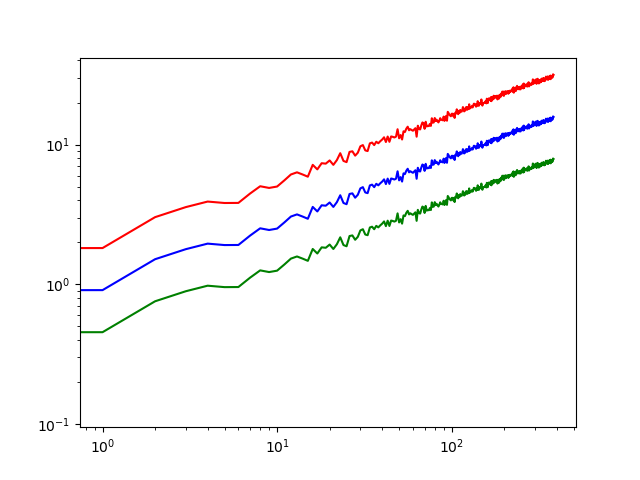

In [176]:
psr = hp.anafast(hp.alm2map(almr, NSIDE))
pst = hp.anafast(hp.alm2map(almt, NSIDE))
psp = hp.anafast(hp.alm2map(almp, NSIDE))

plt.figure()
plt.loglog(np.sqrt(psr * (ell + 1) ) , 'g')
plt.loglog(np.sqrt(pst * (ell + 1) ) , 'b')
plt.loglog(np.sqrt(psp * (ell + 1) ) , 'r')
plt.show()

In [177]:
almp = almt + 1j*almp
almm = almt - 1j*almp
mapr = hp.alm2map(almr, NSIDE)
maph = hp.alm2map_spin([almp, almm], NSIDE, 1, ellmax)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<IPython.core.display.Javascript object>


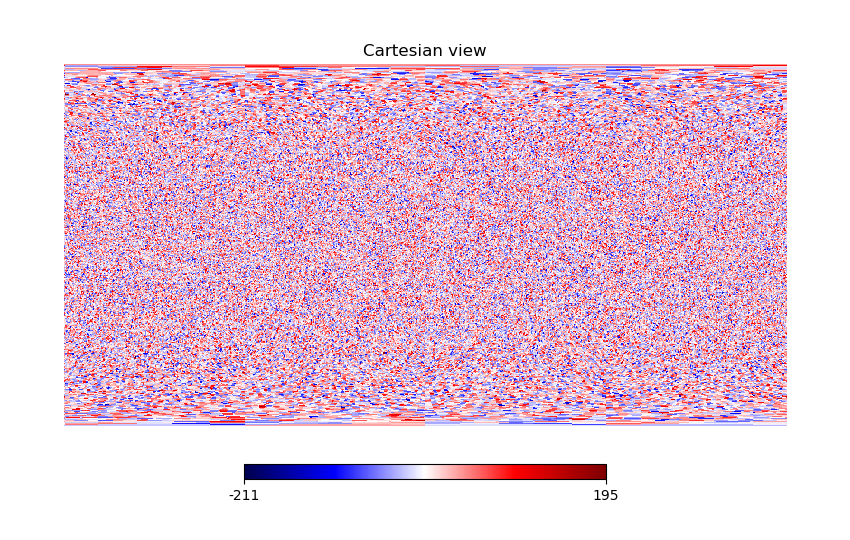

<IPython.core.display.Javascript object>


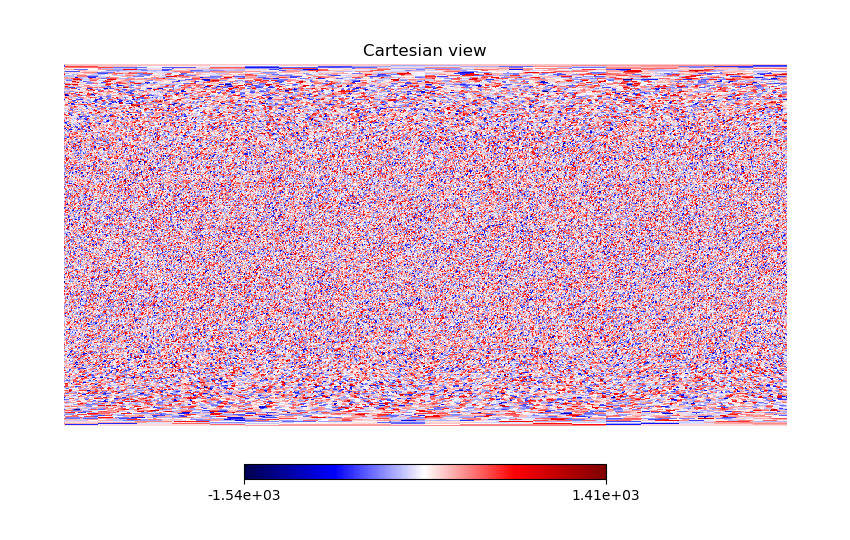

<IPython.core.display.Javascript object>


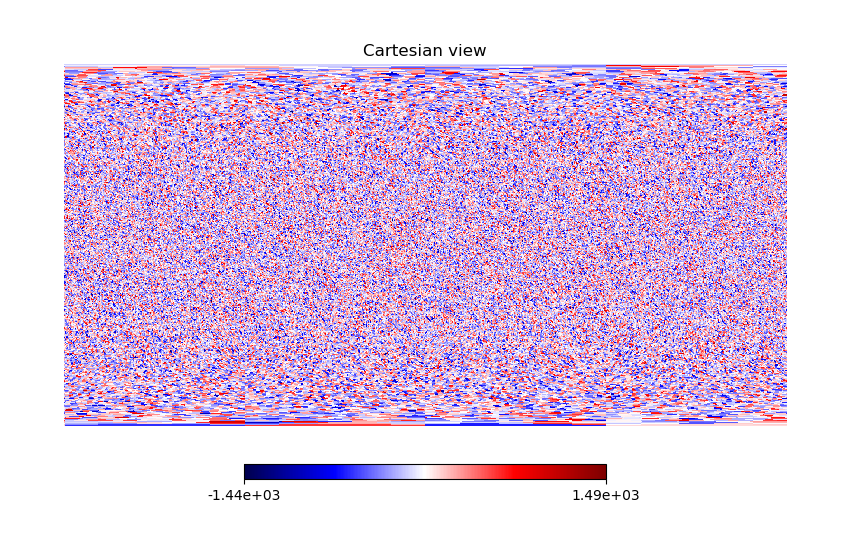

In [178]:
hp.cartview(mapr, cmap='seismic')
hp.cartview(maph[0] + maph[1], cmap='seismic')
hp.cartview(maph[0] - maph[1], cmap='seismic')